In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import f90nml
from salishsea_tools import metric_tools as met

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [2]:
reference_namelist_file = '/data/jpetrie/MEOPAR/SS-run-sets/SS-SMELT/namelists/namelist_pisces_cfg_5x5_NewIC'
reference_bio_params = f90nml.read(reference_namelist_file)

In [3]:
start_month_tracer_file = {"Jun":'SS5x5_1h_20150601_20150829_ptrc_T.nc',
                           "Feb":'SS5x5_1h_20150201_20150501_ptrc_T.nc'}

param_metrics = pd.DataFrame()

batch_directories = [
                     '/data/jpetrie/MEOPAR/SalishSea/results/all_params_JuneIC_june_21/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampiszoo_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisopt_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismes_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampissink_june_17/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisprod_june_16/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismort_june_17/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisrem_june_17/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismezo_june_20/',
]

metric_func_list = [
                    met.mean_NH4_at_depth,
                    met.mean_NO3_at_depth,
                    met.mean_DON_at_depth,
                    met.mean_PON_at_depth,
                    met.time_of_peak_PHY2,
                    met.time_surface_NO3_drops_below_4,
                    met.peak_3_day_biomass,
]
for batch_dir in batch_directories:
    for file in os.listdir(batch_dir):
        if 'zz_frac_waste' not in file:
            found_tracer_file = False
            for start_month in start_month_tracer_file:
                if os.path.isfile(batch_dir + '/' + file + '/' + start_month_tracer_file[start_month]):
                    found_tracer_file = True
                    break
            if found_tracer_file is True: 
                last_underscore = file.rfind('_')
                first_underscore = file.find('_')
                param_section = file[:first_underscore]
                param_name = file[(first_underscore+1):last_underscore]
                param_val = float(file[(last_underscore+1):])
                param_desc = param_section + ' ' + param_name

                original_val = reference_bio_params[param_section][param_name]

                if type(original_val) is list:
                    param_scale = round(param_val/original_val[0], 3)
                else:
                    param_scale = round(param_val/original_val, 3)

                grid_t = xr.open_dataset(batch_dir + '/' + file +'/' + start_month_tracer_file[start_month])

                for metric_func in metric_func_list:
                    metric_val = metric_func(grid_t)
                    metric_name = metric_func.__name__
                    # inefficient to keep appending, but much less expensive than other parts of the loop so it doesn't matter
                    param_metrics = param_metrics.append(pd.DataFrame({"PARAM_SECTION":[param_section],
                                                                       "PARAM_NAME":[param_name],
                                                                       "PARAM_DESC":[param_desc],
                                                                       "PARAM_VAL":[param_val],
                                                                       "PARAM_SCALE":[param_scale],
                                                                       "METRIC_NAME":[metric_name],
                                                                       "METRIC_VAL": [metric_val],
                                                                       "START_MONTH":[start_month]}))


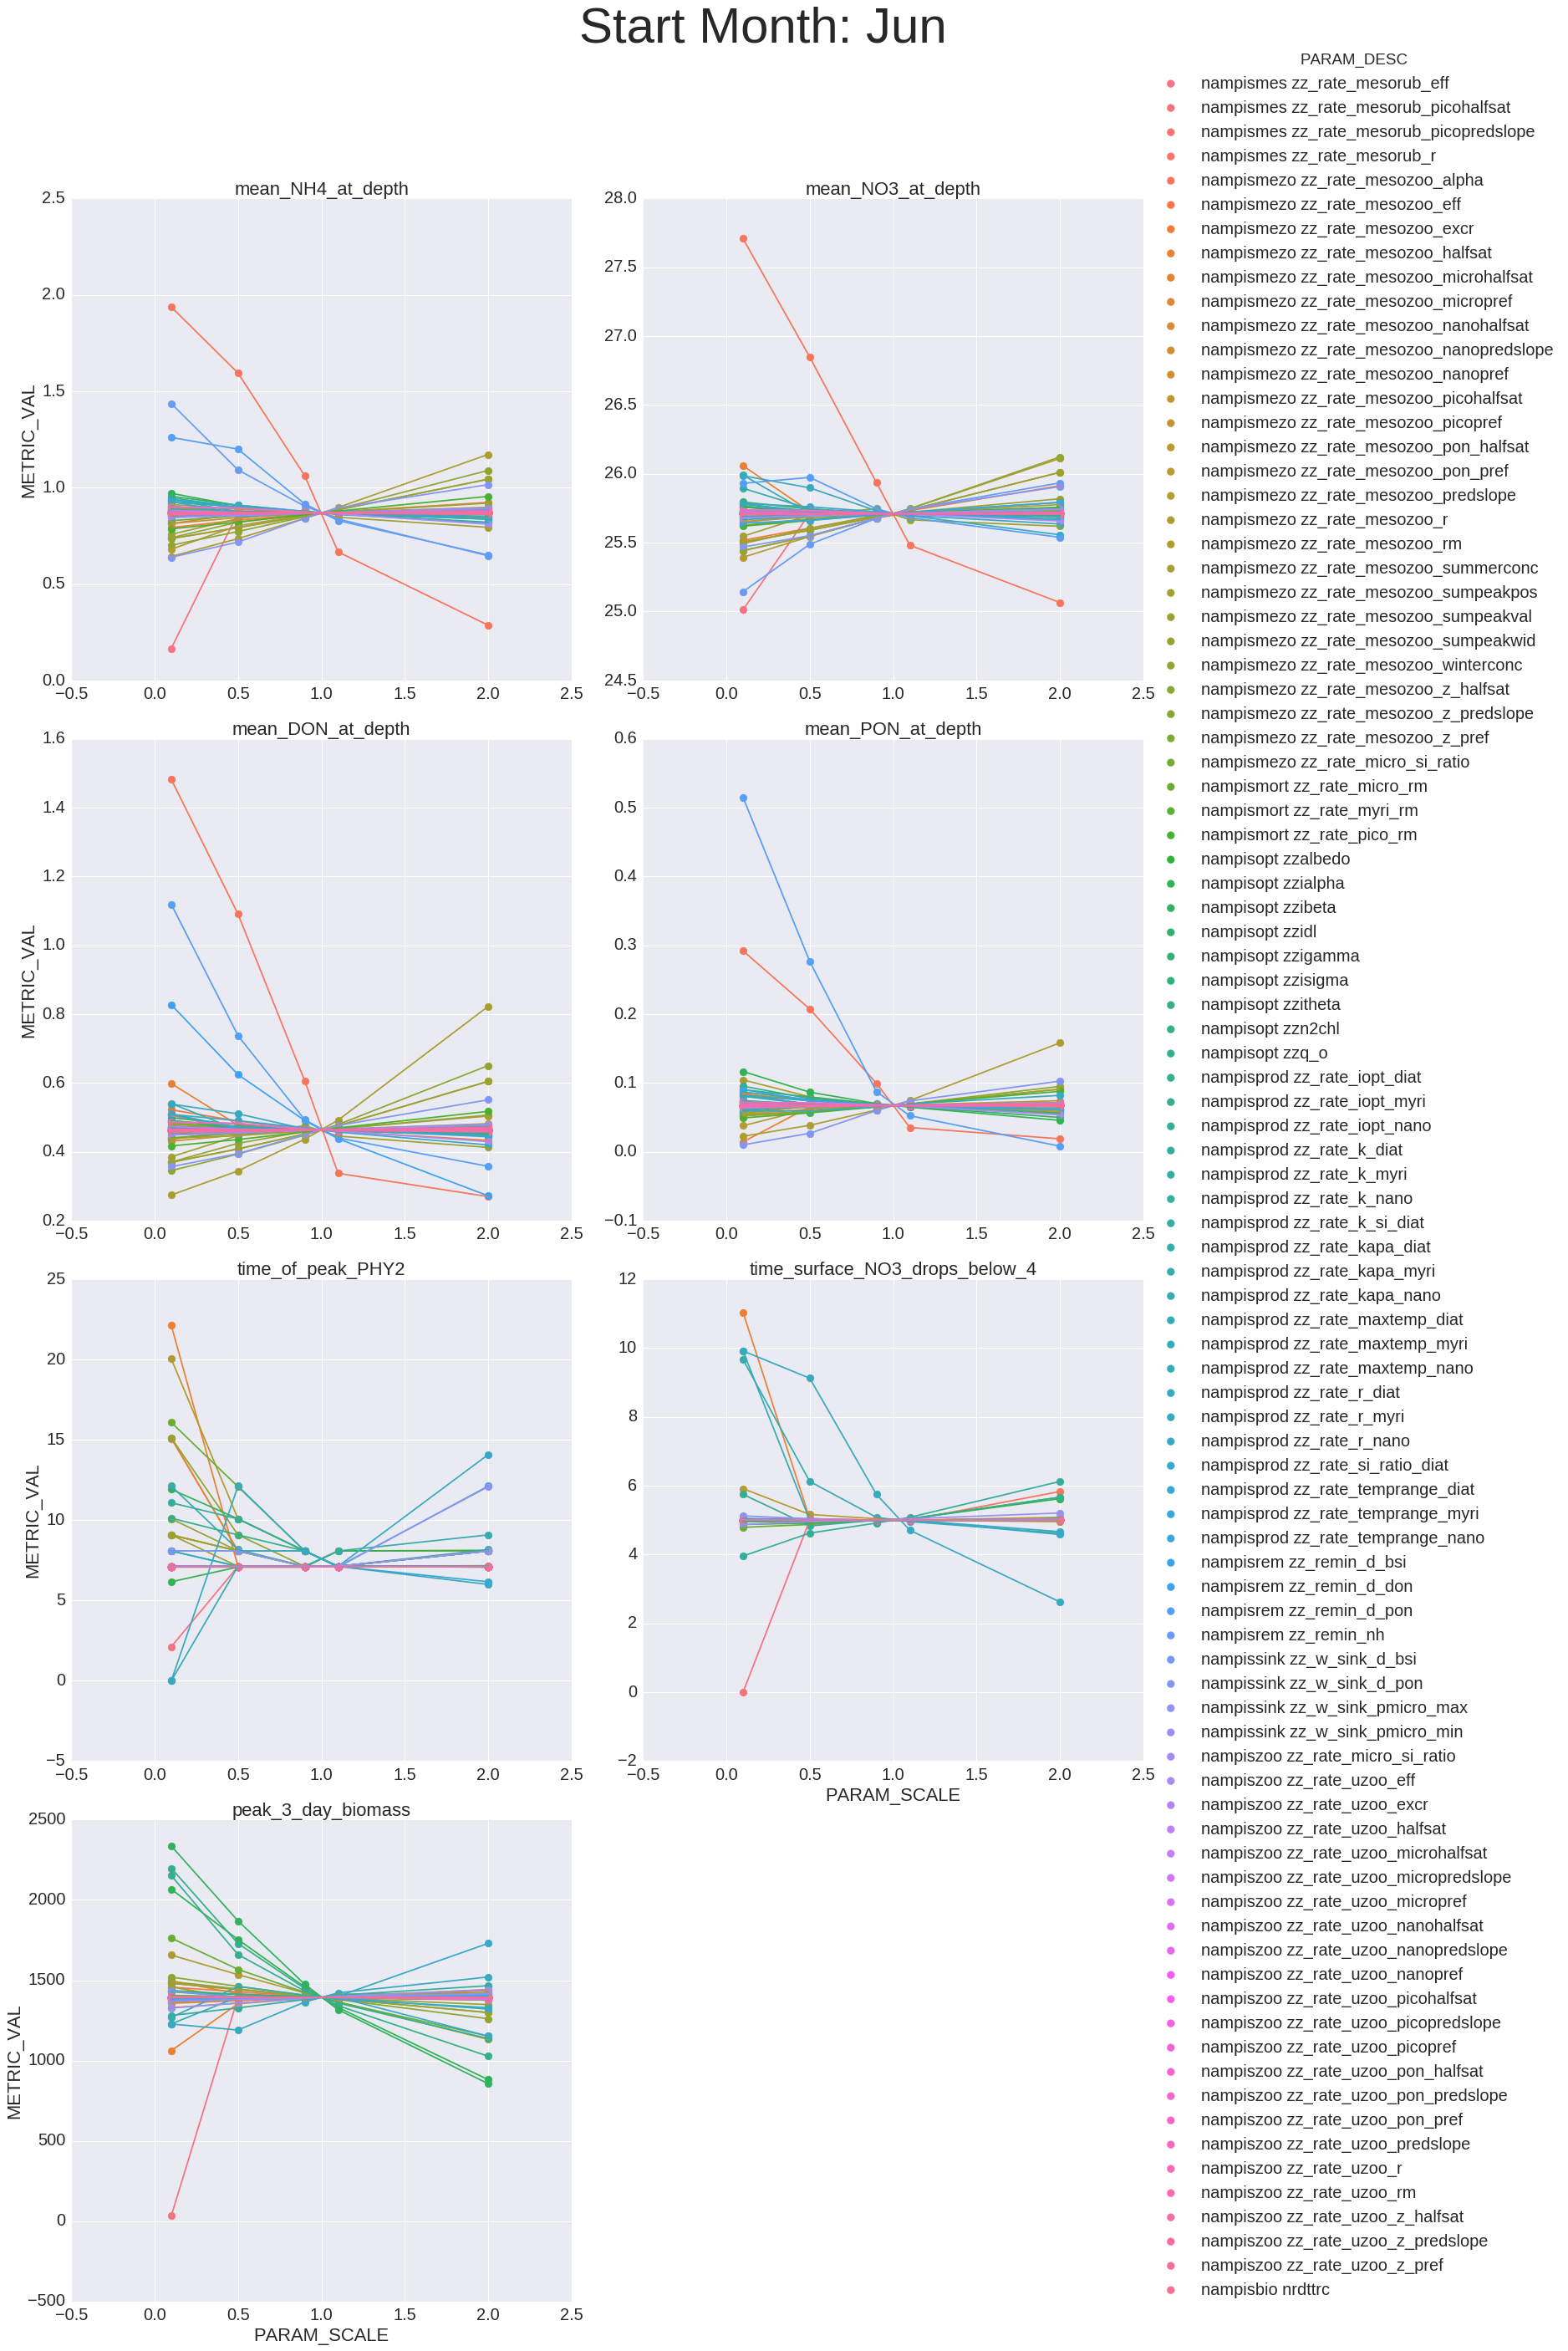

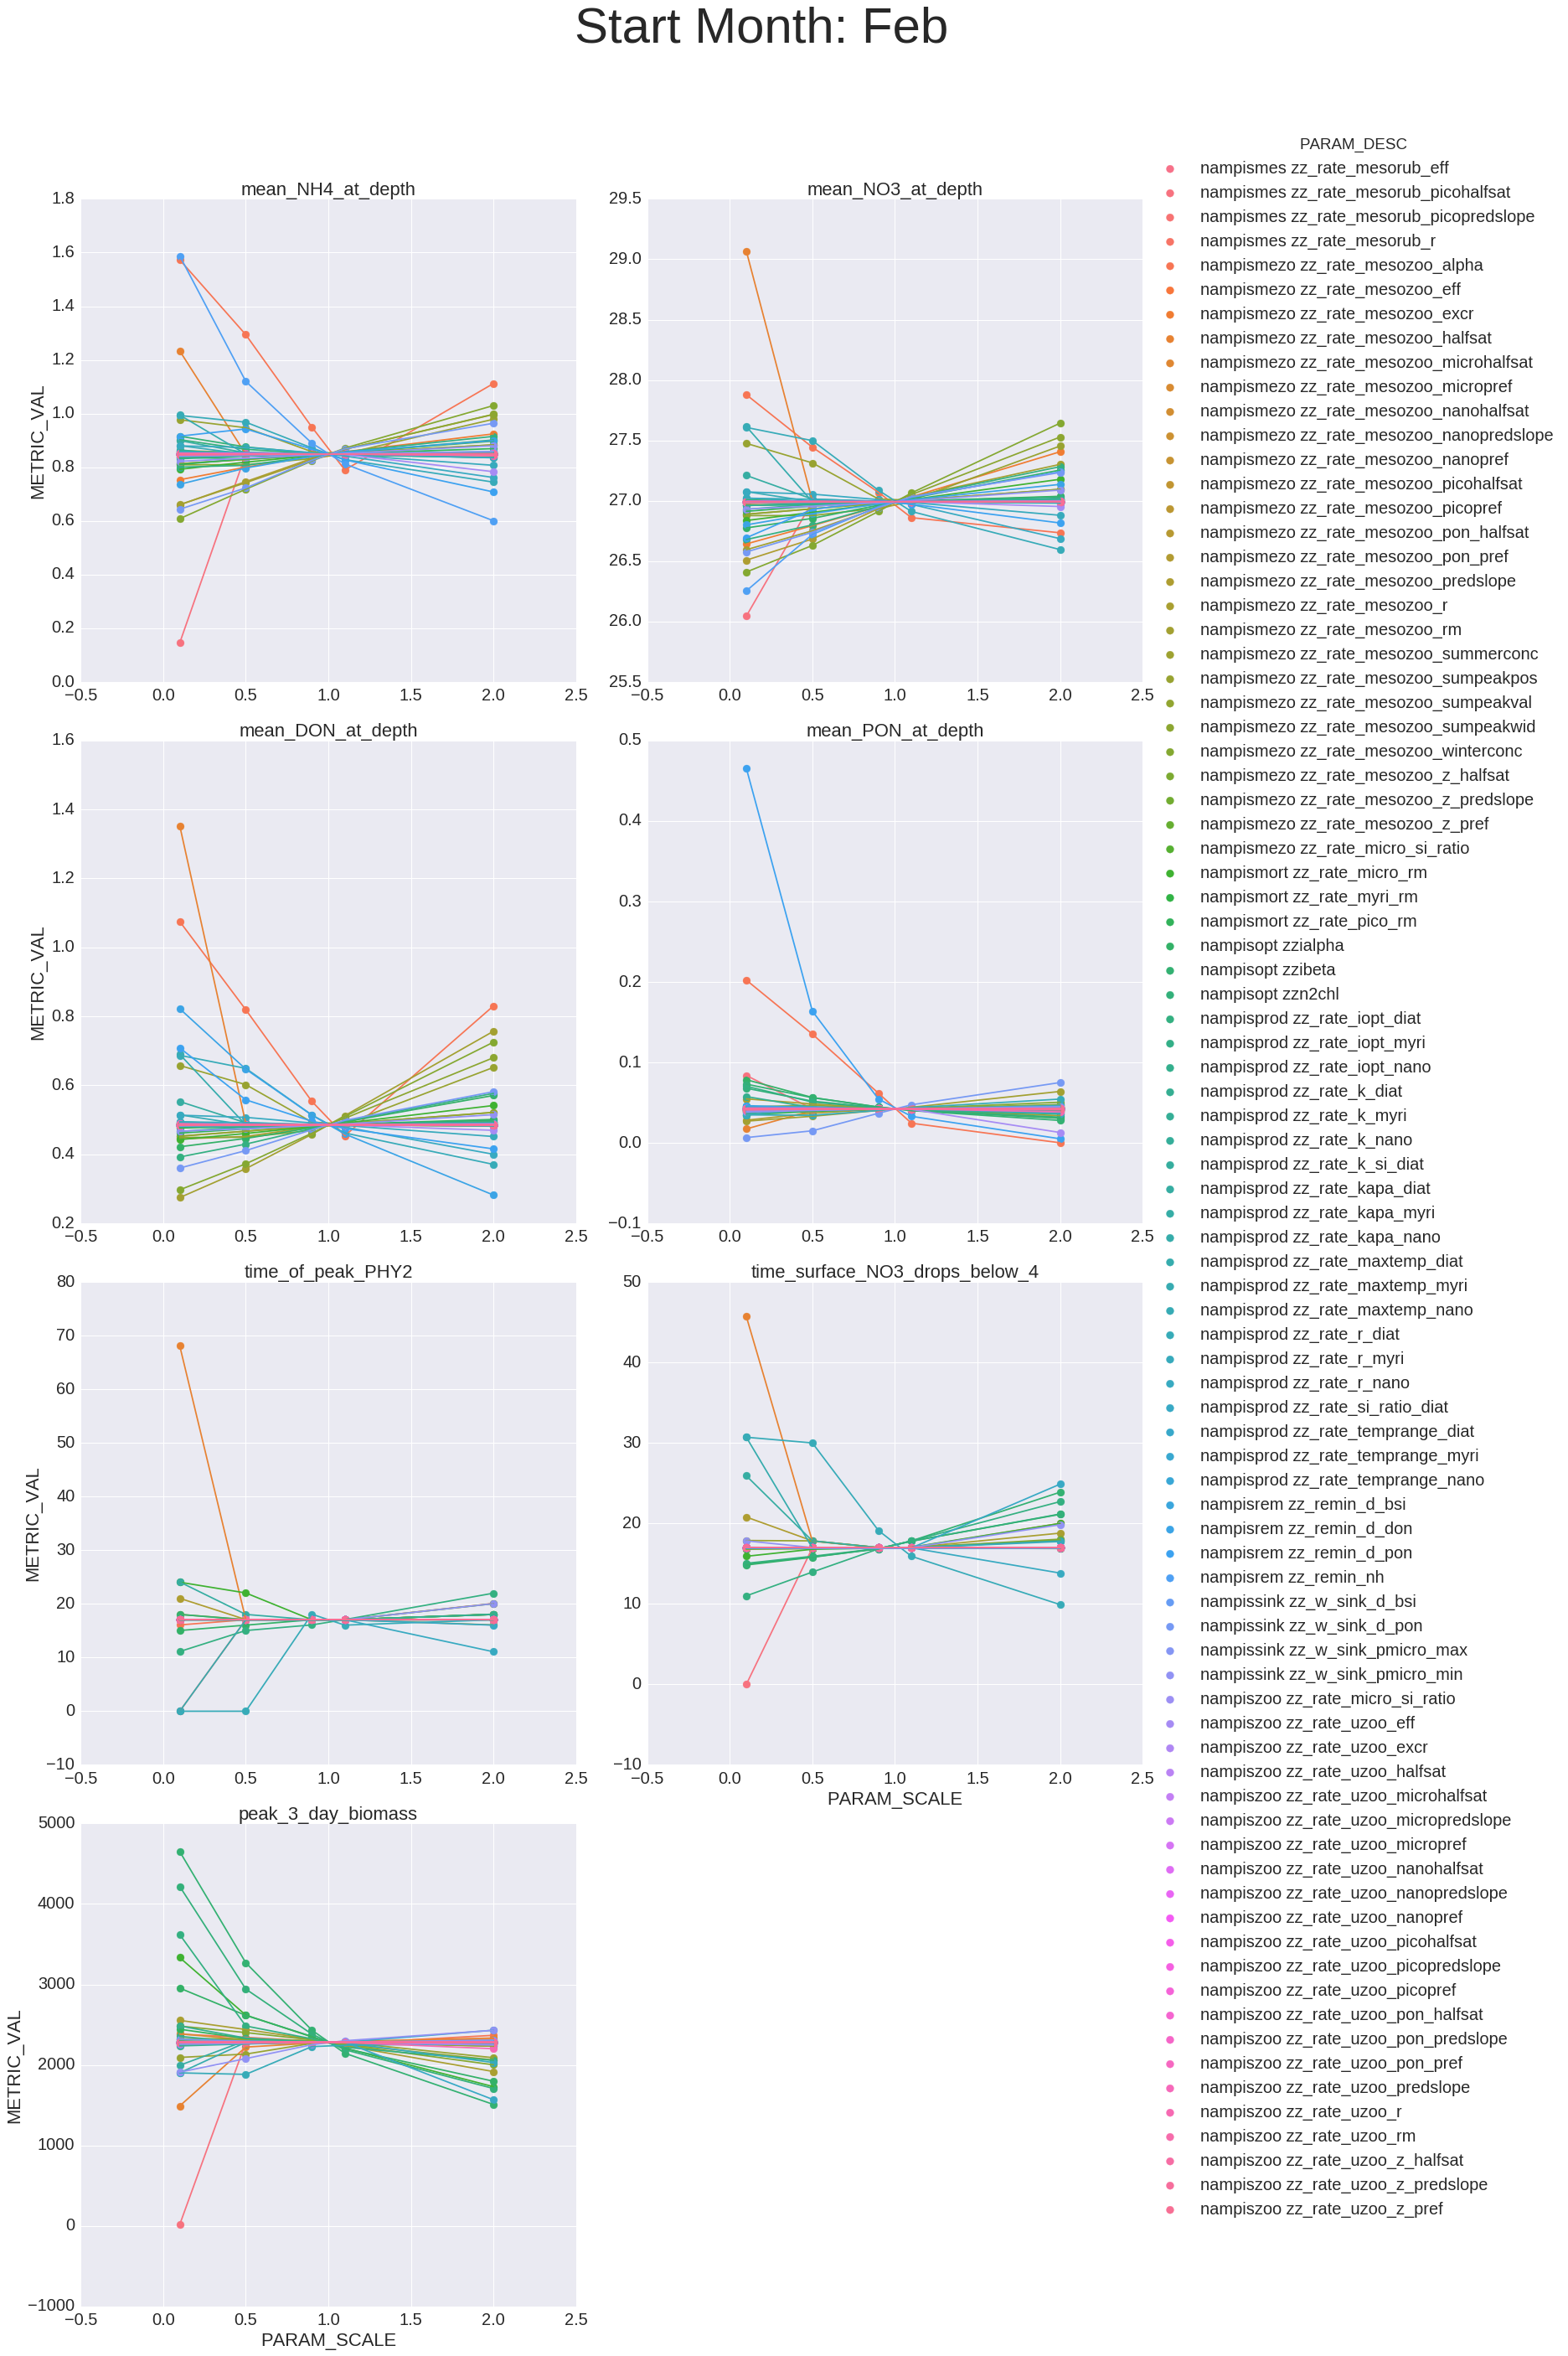

In [43]:
sns.set(font_scale = 2)
plt.rcParams['image.cmap'] = 'jet'

param_metrics = param_metrics.sort_values(["PARAM_SCALE", "PARAM_DESC"])

for start_month in start_month_tracer_file.keys():
    fg = sns.FacetGrid(data=param_metrics.query("PARAM_SCALE < 10 and START_MONTH == @start_month"), col = "METRIC_NAME", hue = "PARAM_DESC", sharex=False, sharey=False, col_wrap = 2, size = 10)
    fg.map(plt.scatter, "PARAM_SCALE", "METRIC_VAL", s = 80)
    fg.map(plt.plot, "PARAM_SCALE", "METRIC_VAL")
    fg.add_legend()
    fg.set_titles("{col_name}")
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle("Start Month: " + start_month, fontsize=60)

In [9]:
param_metrics["PARAM_SCALE_STR"] = param_metrics["START_MONTH"] + "_PARAM_SCALE_" + param_metrics["PARAM_SCALE"].astype(str)
wide_format_metrics = pd.pivot_table(param_metrics, values='METRIC_VAL', index=['PARAM_SECTION','PARAM_NAME', 'PARAM_DESC', 'METRIC_NAME'], columns=['PARAM_SCALE_STR'])
wide_format_metrics.reset_index(inplace=True)
for start_month in start_month_tracer_file.keys():
    wide_format_metrics[start_month + "IC_SLOPE"] = (wide_format_metrics[start_month + "_PARAM_SCALE_1.1"] - wide_format_metrics[start_month + "_PARAM_SCALE_0.9"])/0.2

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


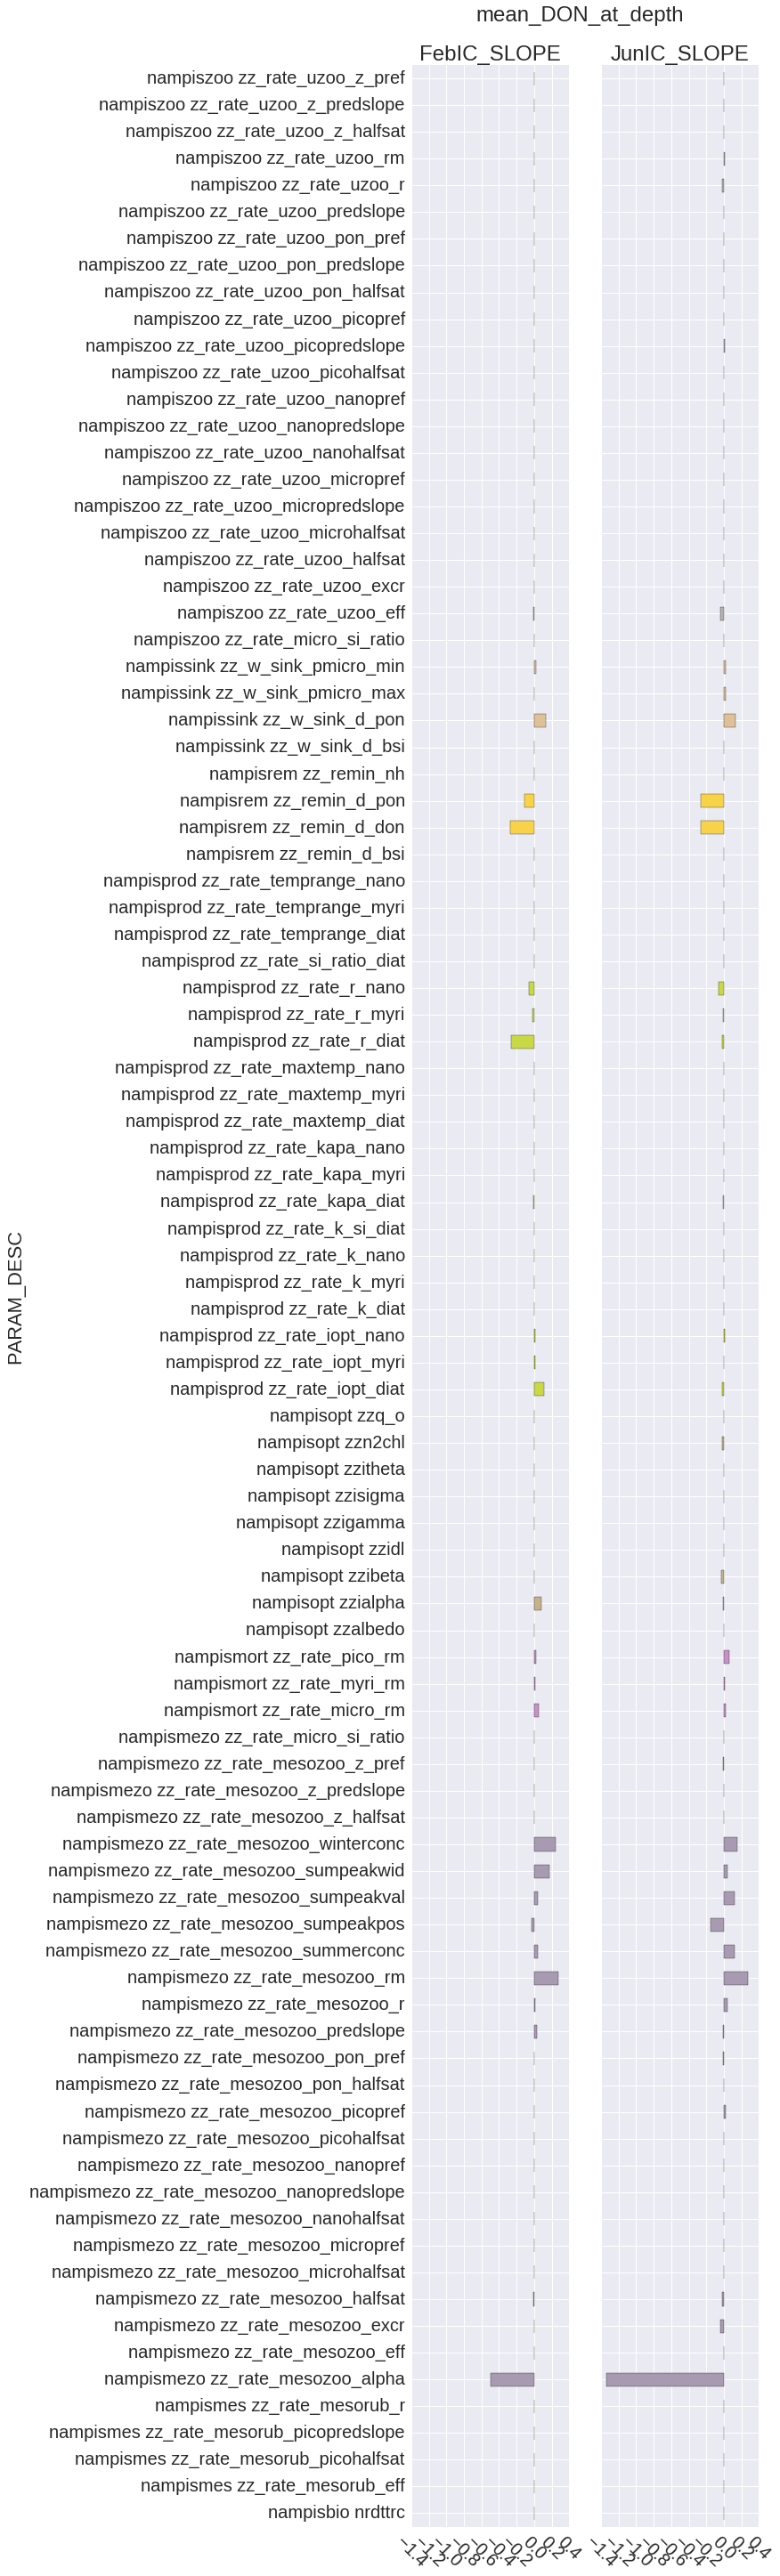

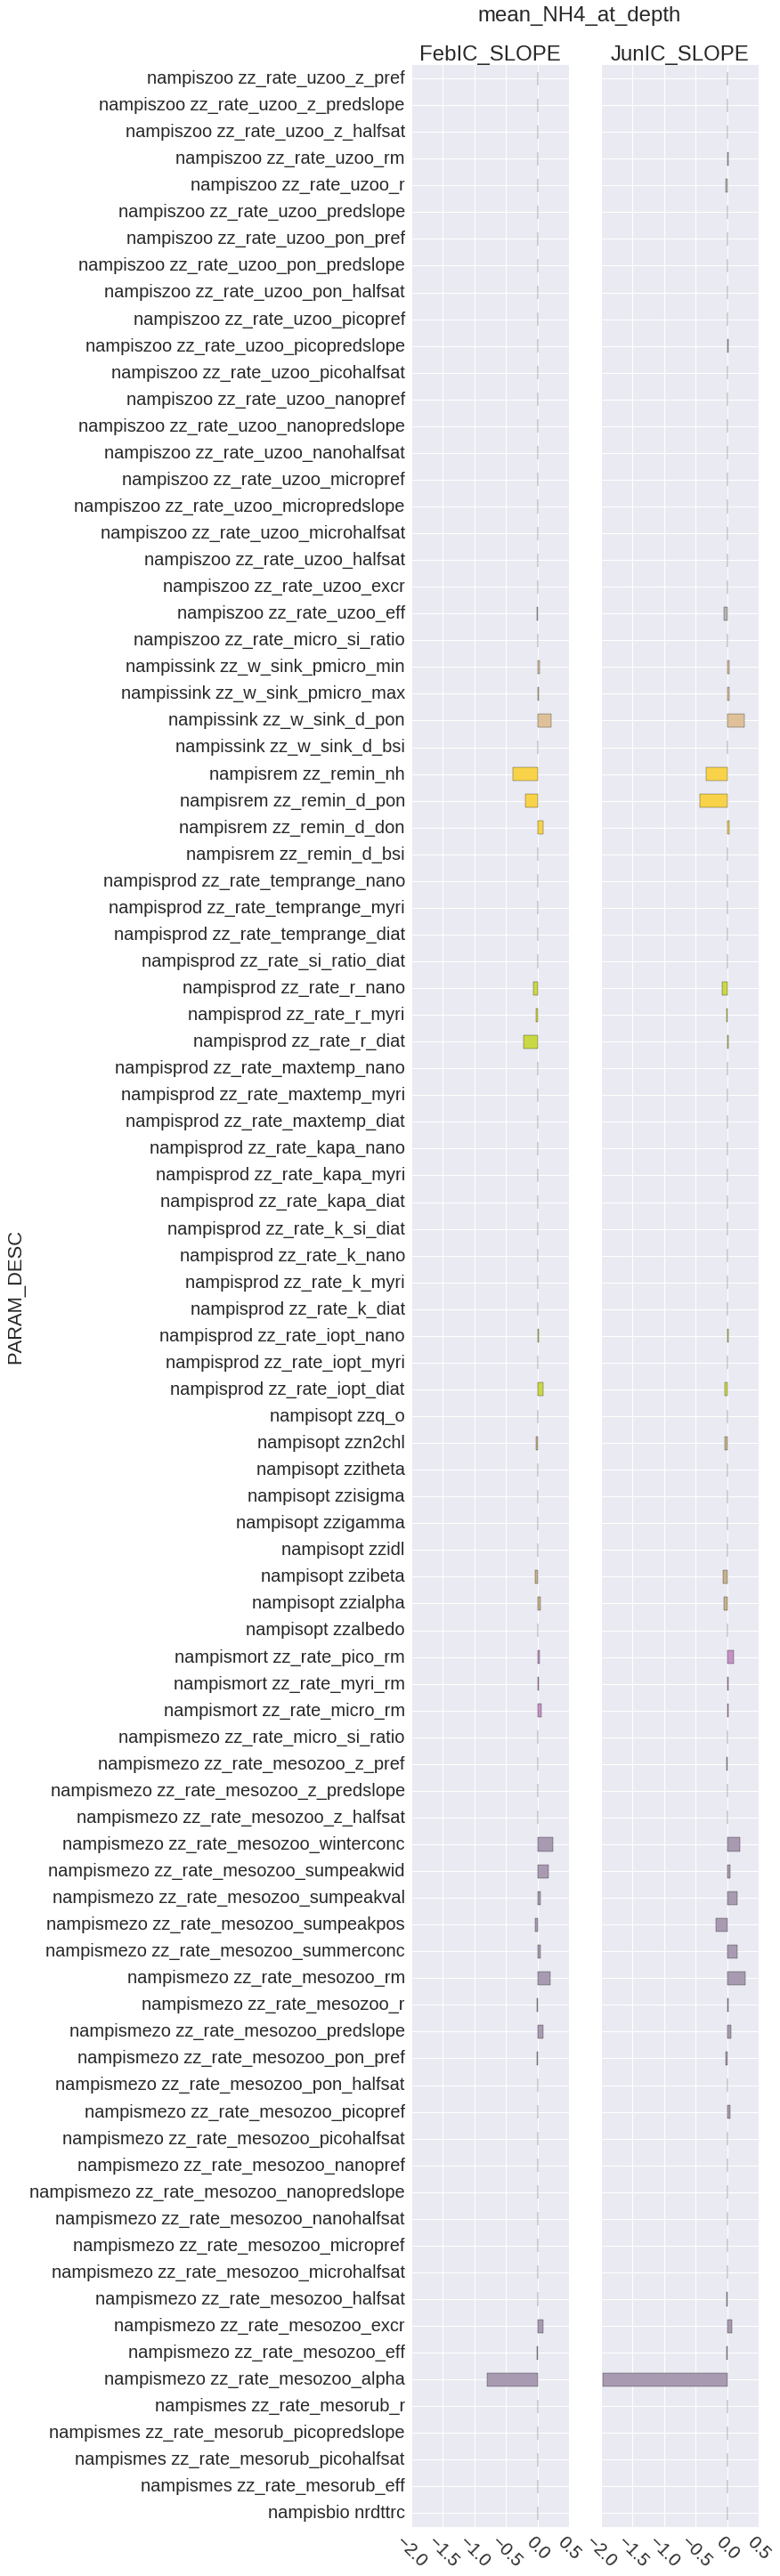

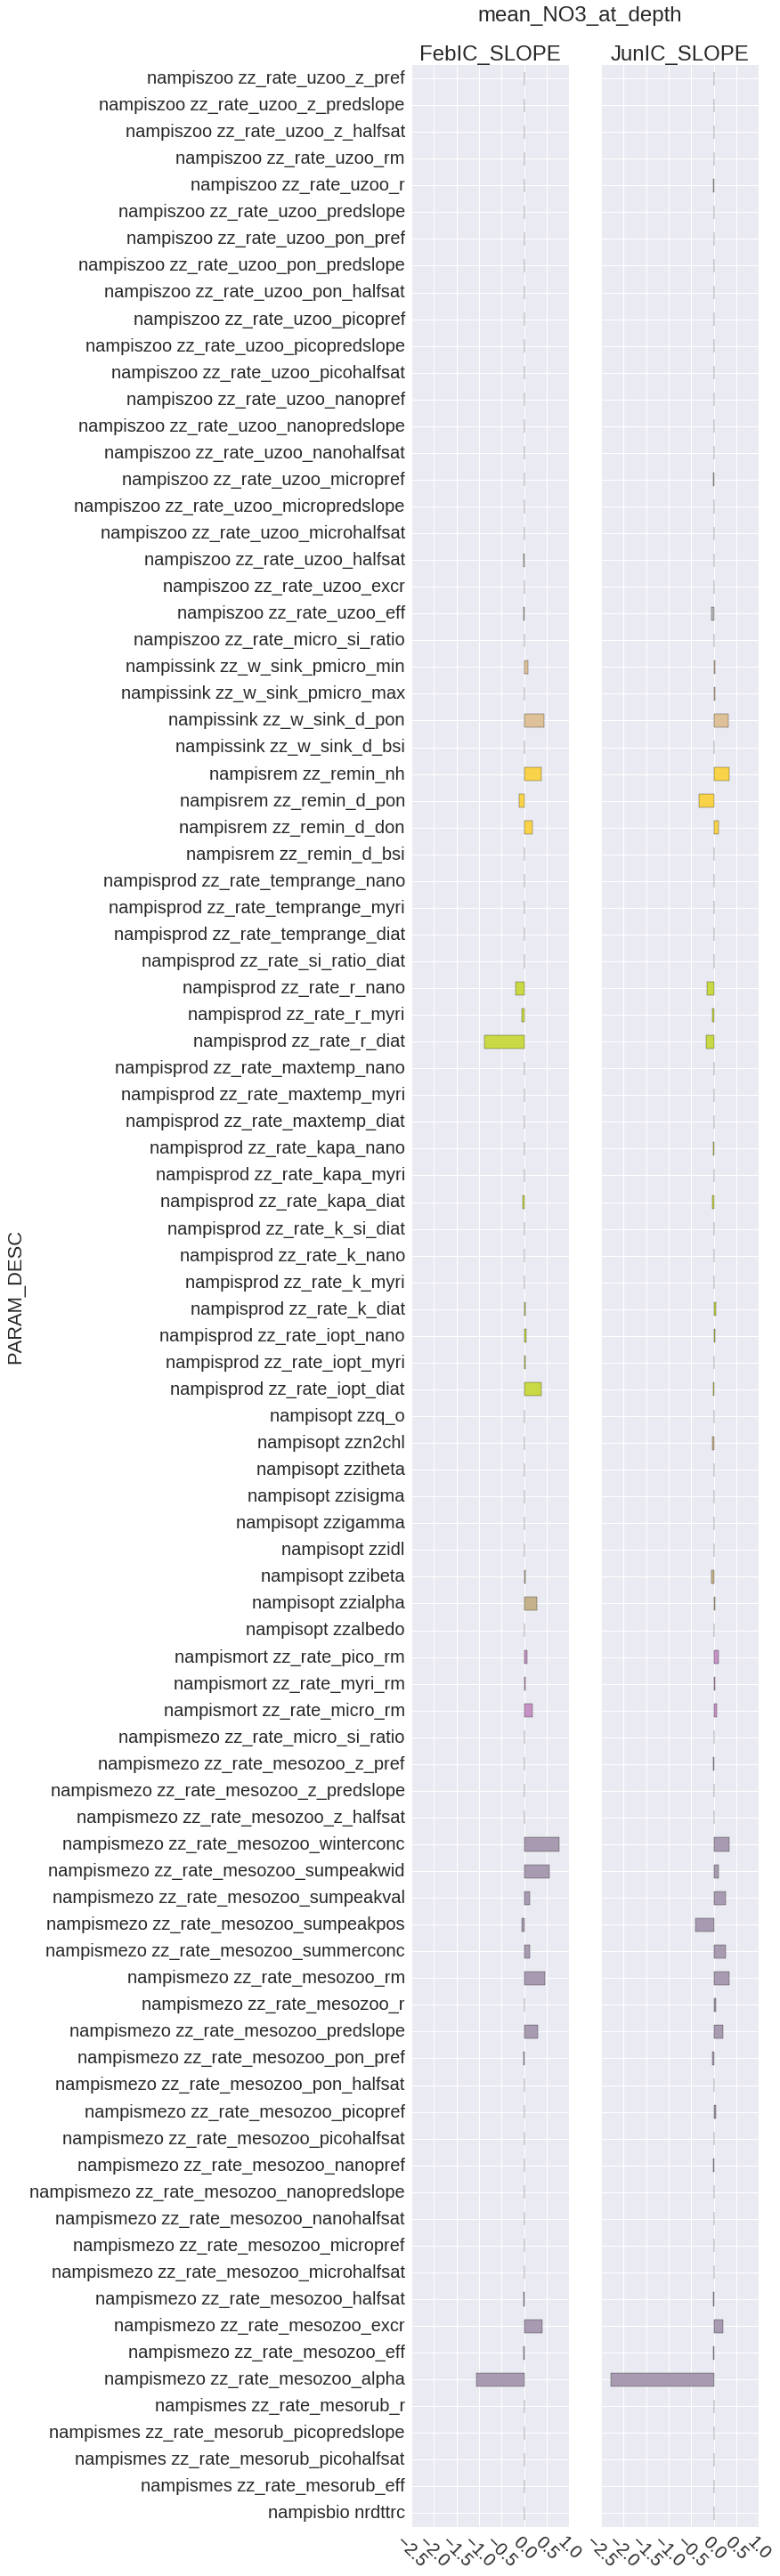

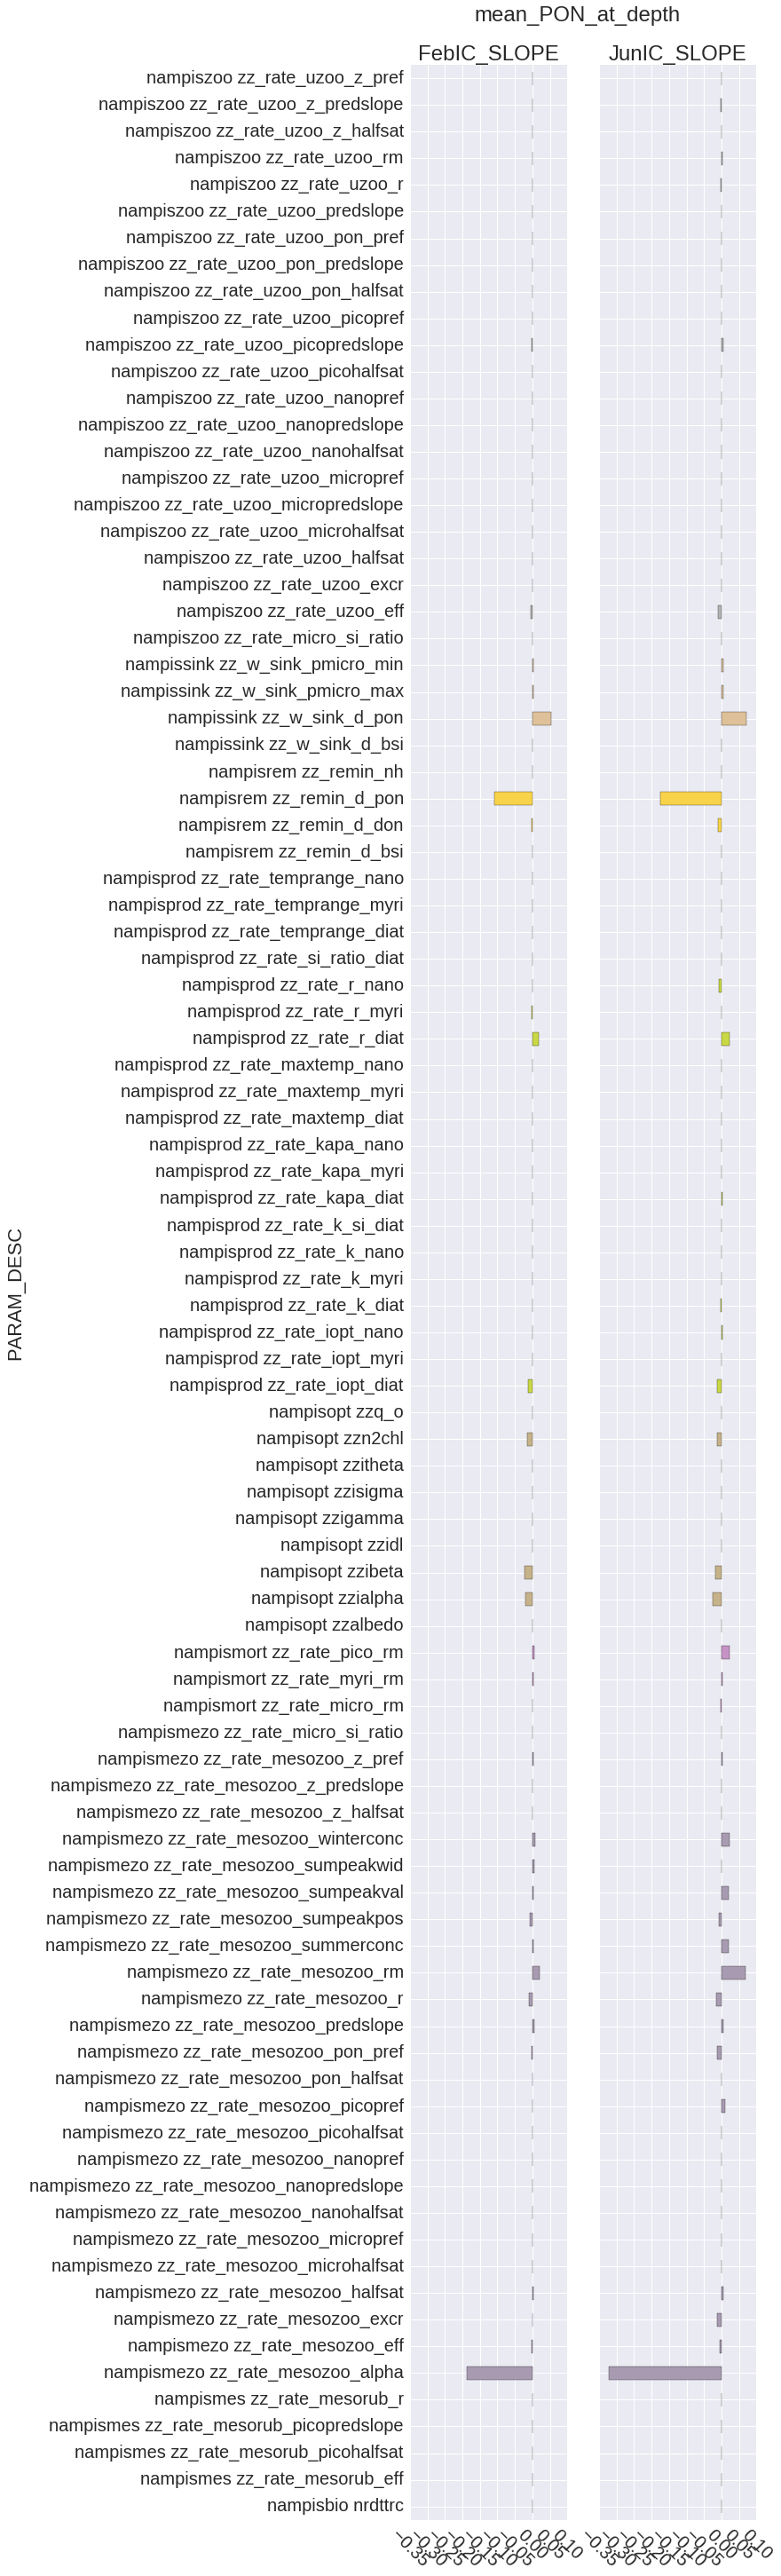

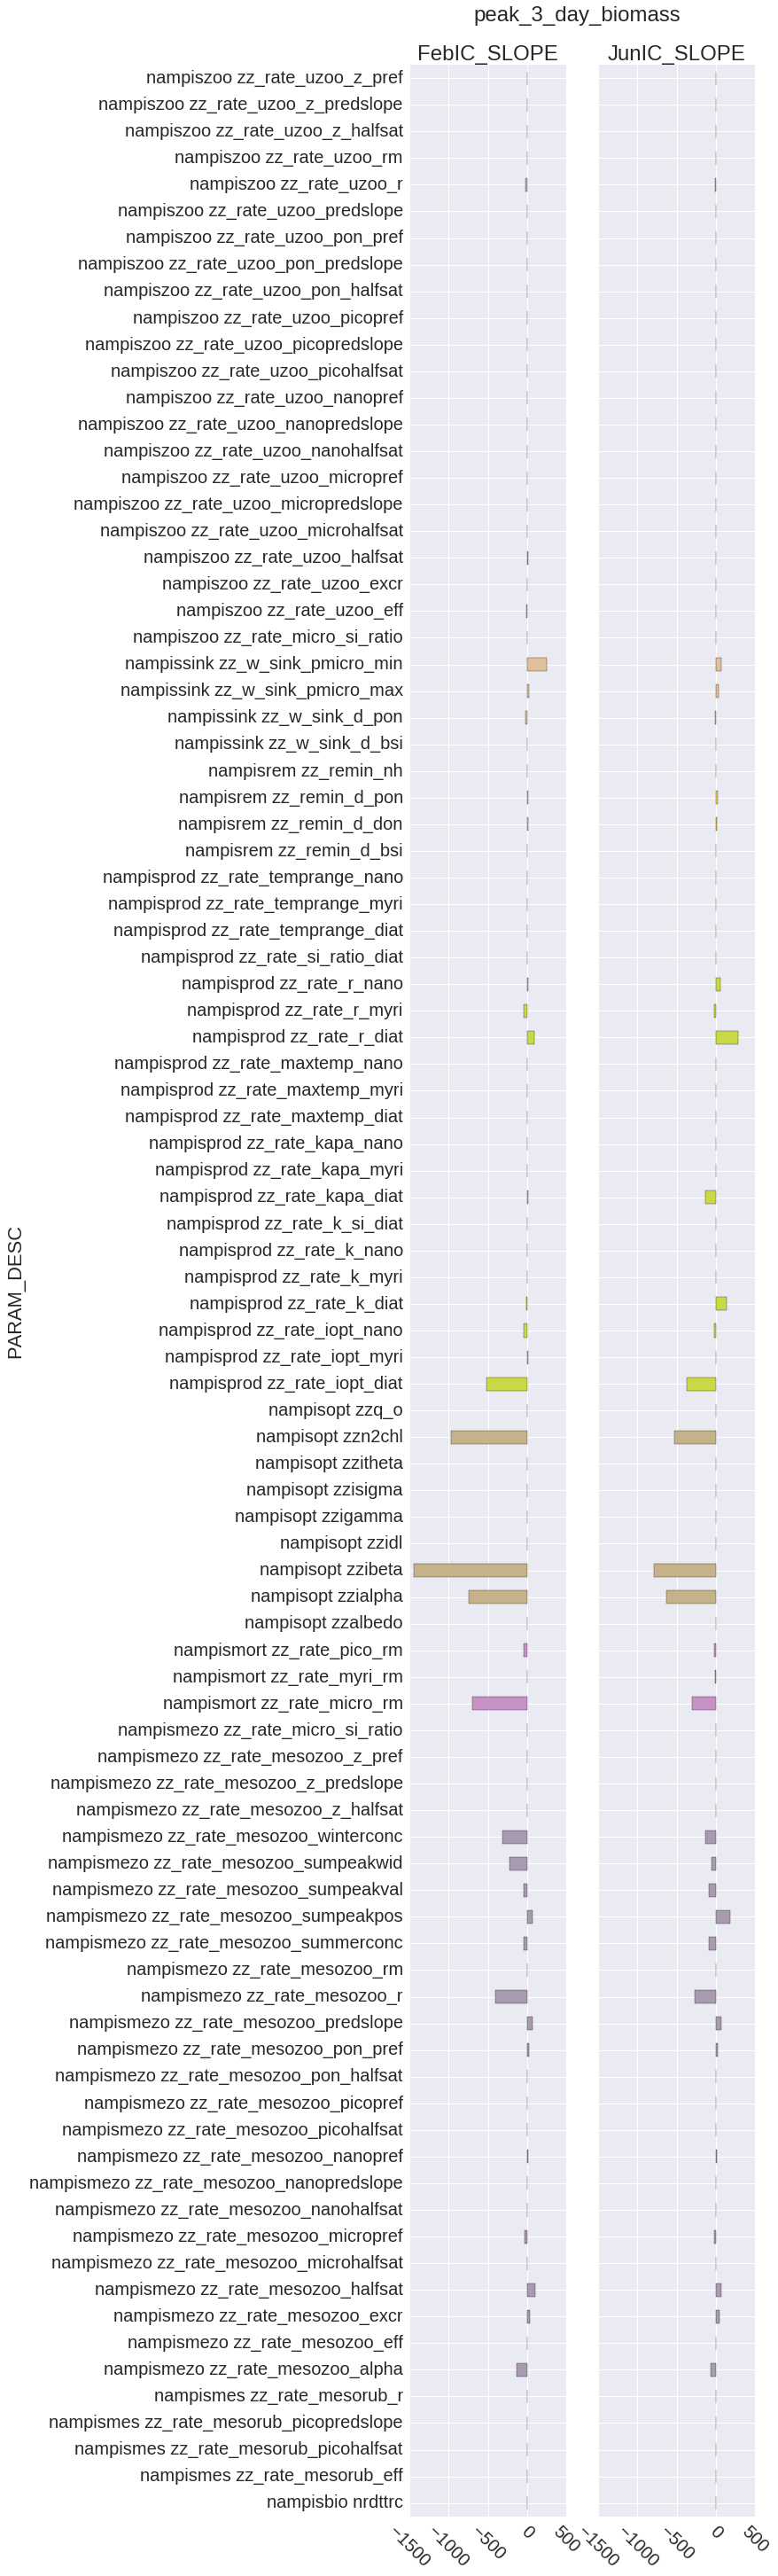

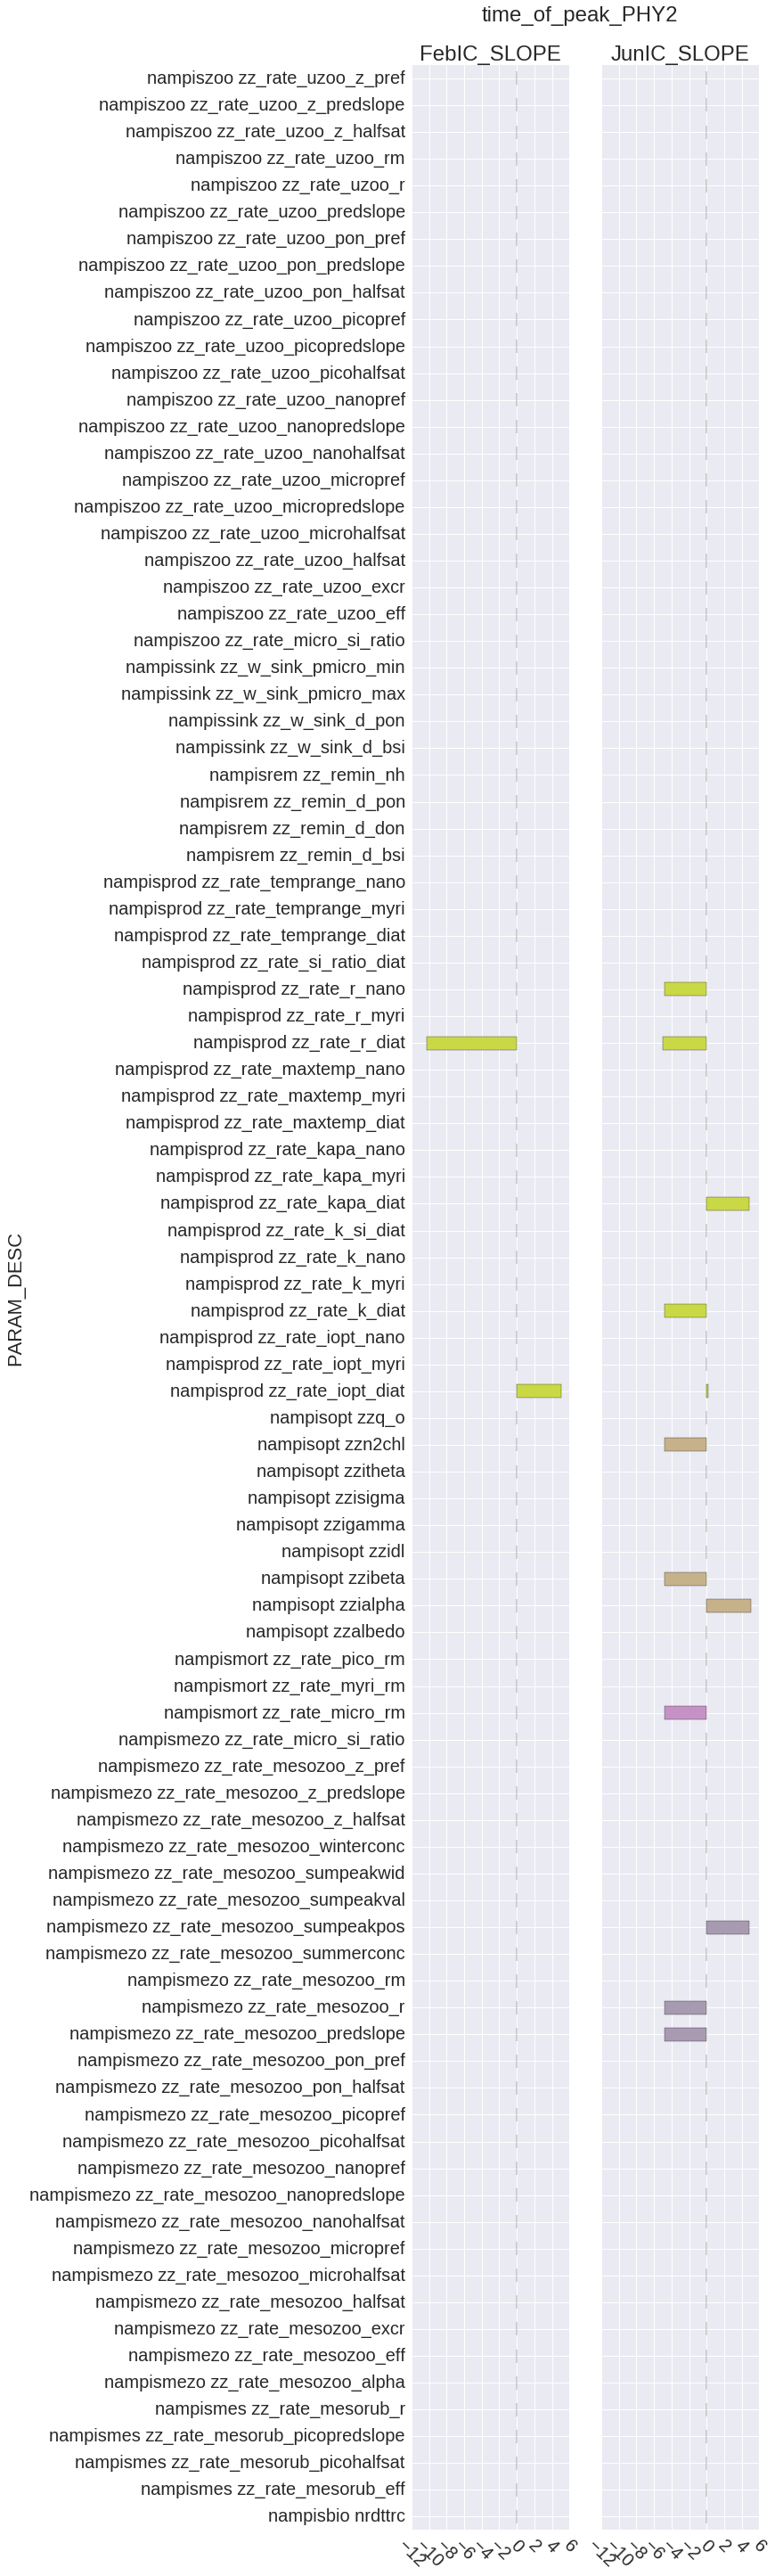

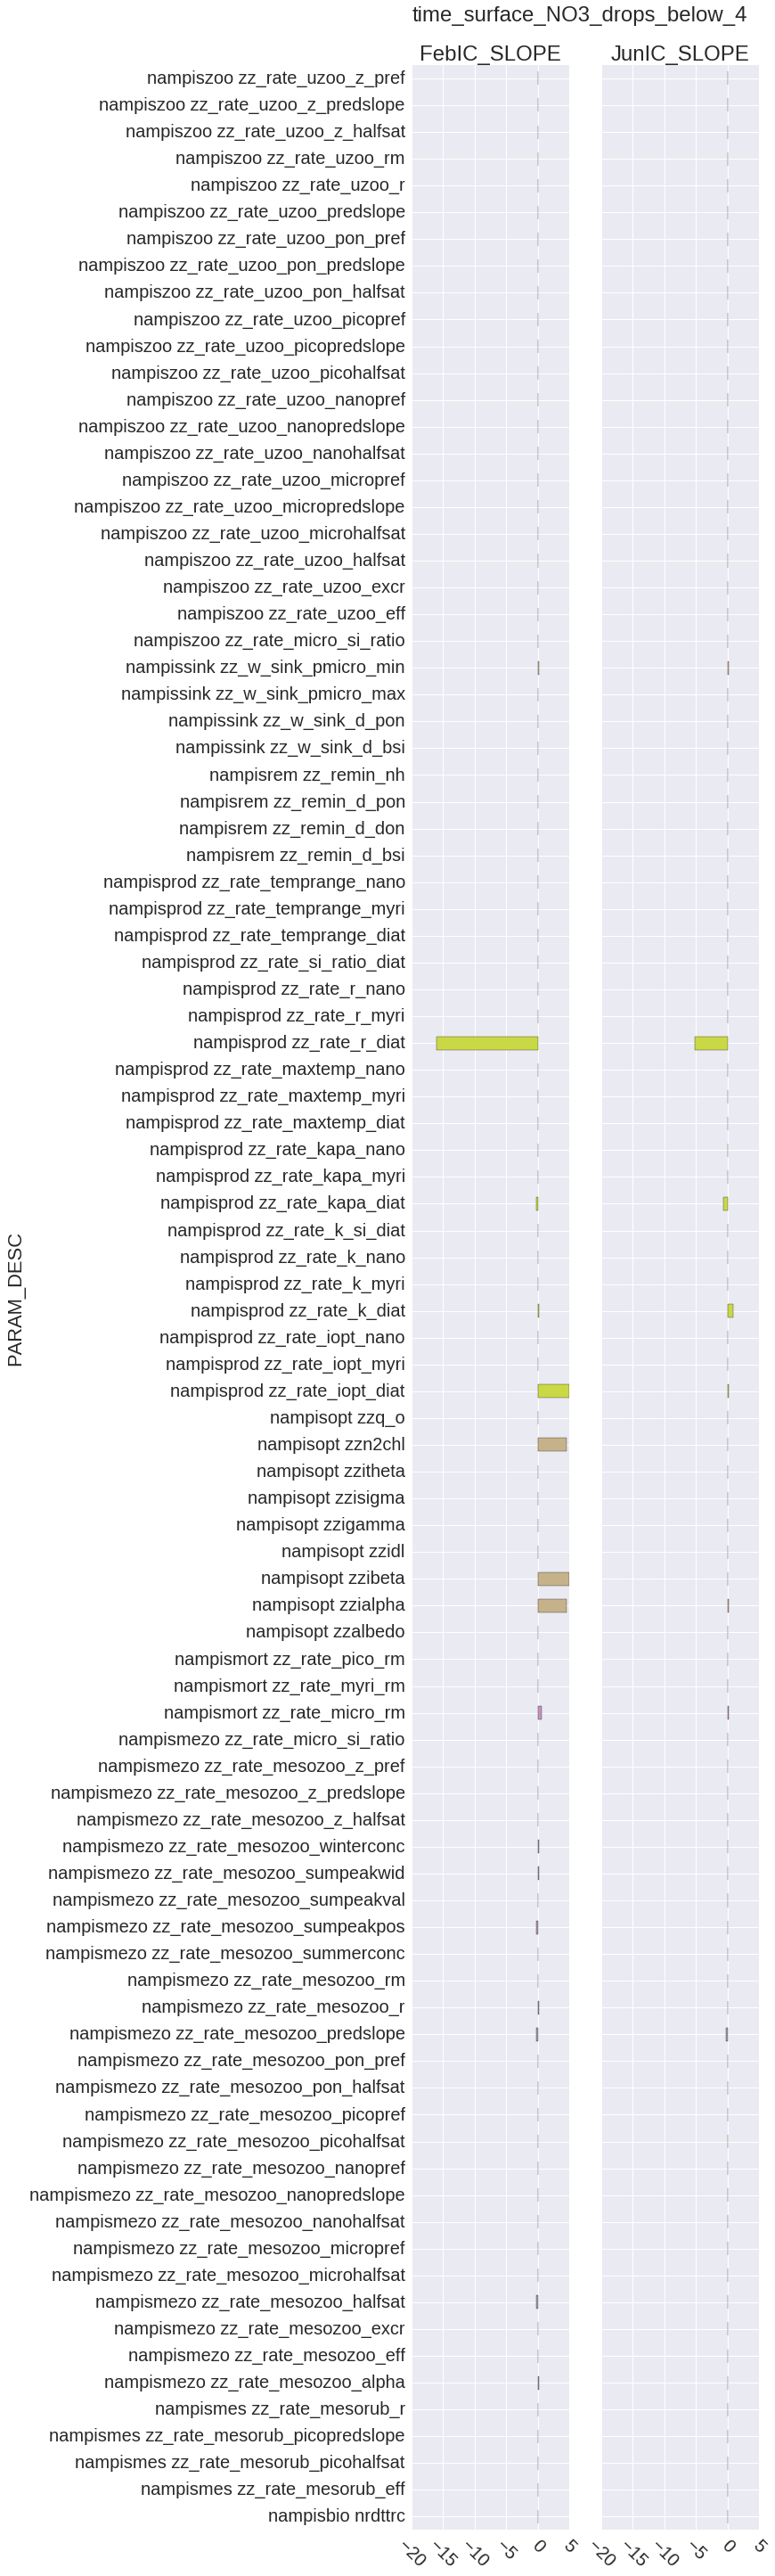

In [38]:
cmap = plt.get_cmap('Set2')
for metric_name in np.unique(wide_format_metrics["METRIC_NAME"]):
    x = wide_format_metrics.query("METRIC_NAME == @metric_name")
    
    categories = np.unique(x["PARAM_SECTION"])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  
    x["COLOR"] = x["PARAM_SECTION"].apply(lambda x: colordict[x])
    
    axes = x.plot("PARAM_DESC",  ["FebIC_SLOPE", "JunIC_SLOPE"],kind = 'barh', figsize = (7,0.5*len(x["FebIC_SLOPE"])),  title = metric_name, subplots = True, sharex = True, sharey = True, layout = (1,2),color = [cmap(x.COLOR), cmap(x.COLOR)], legend = False)
    plt.subplots_adjust(top=0.96)
    for i in range(2):
        for tick in axes[0,i].get_xticklabels():
            tick.set_rotation(-45)